# Load Packages

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Import packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import requests
import pyunpack
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import sys

from rarfile import RarFile
import segmentation_models as sm
from keras_segmentation.models import segnet
from tensorflow.keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/imageio/core/util.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Functions

In [2]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score

  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

# Ingest and Process 4-band Dataset

In [ ]:
# Ingest images and normalise
base_dir2 = r"./mangrove_datasets/MIXED_KALIMANTAN/"

## Training images
training_images_list2 = os.listdir(r"{}Training/images/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  if n == '.DS_Store':
    continue
  training_masks_list2.append((n[:-4]+'.png'))
  a = (np.array(rxr.open_rasterio(r"{}Training/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/masks/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
# test_images_list2 = os.listdir(r"{}Test/".format(base_dir2))
# test_images2 = []
# for n in test_images_list2:
#   if n == '.DS_Store':
#     continue
#   a = (np.array(rxr.open_rasterio(r"{}Test/{}".format(base_dir2,n))))
#   a = (a-np.min(a)) / (np.max(a)-np.min(a))
#   test_images2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  if n == '.DS_Store':
    continue
  validation_masks_list2.append(n[:-4]+'.png')
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no 

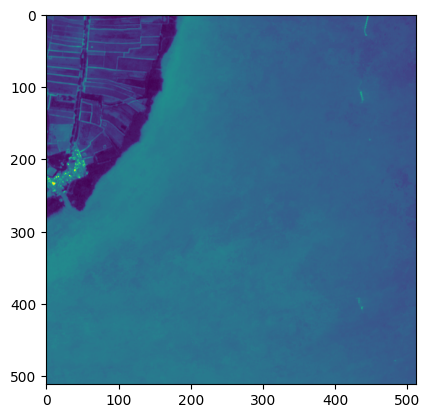

In [4]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/images/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [5]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  m = np.array(training_masks2[i]).astype('float32')
  m = (m > 0).astype('float32')
  m = m.reshape(1,512,512,1)
  training_masks2[i] = m.T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  m = np.array(validation_masks2[i]).astype('float32')
  m = (m > 0).astype('float32')
  m = m.reshape(1,512,512,1)
  validation_masks2[i] = m.T

test_images2 = []
for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [6]:
# # Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

# Models

## U-Net (Unmodified)

In [7]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [8]:
# Print model layers and number of parameters
UNet().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (1, 512, 512, 64)            1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (1, 512, 512, 64)            0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (1, 512, 512, 64)            36928     ['activation[0][0]']          
                                                                                              

## Attention U-Net (Unmodified)

In [9]:
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose,
    MaxPooling2D, UpSampling2D, Activation, concatenate, add, Multiply, BatchNormalization, LeakyReLU, Dropout
)

'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,6), drop_rate = 0.25, lr=0.0001, filter_base=16, se_reduction=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [10]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(1, 512, 512, 6)]           0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (1, 512, 512, 16)            880       ['input_2[0][0]']             
                                                                                                  
 activation_19 (Activation)  (1, 512, 512, 16)            0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (1, 512, 512, 16)            2320      ['activation_19[0][0]']       
                                                                                            

## Modified Attention U-Net (with Batch Normalization, Leaky ReLU Activation, and Dropout)

In [11]:
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose,
    MaxPooling2D, UpSampling2D, Activation, concatenate, add, Multiply, BatchNormalization, LeakyReLU, Dropout
)

def advancedConvBlock2(input, filters, kernel, kernel_init='he_normal', transpose=False, use_dropout=False, dropout_rate=0.3):
  if transpose == False:
    conv = Conv2D(filters,
                               kernel,
                               padding='same',
                               kernel_initializer=kernel_init,
                               use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
  else:
    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

  if use_dropout:
      conv = Dropout(dropout_rate)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM_Optimized(trained_weights = None, input_size = (512,512,6), drop_rate = 0.25, lr=0.0001, filter_base=16, se_reduction=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = advancedConvBlock2(inputs, filter_base, kernel=3, use_dropout=False)


    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = advancedConvBlock2(conv0, 2 * filter_base, kernel=3, use_dropout=False)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = advancedConvBlock2(pool0, 4 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = advancedConvBlock2(pool1, 8 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = advancedConvBlock2(pool2, 16 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = advancedConvBlock2(conv4, 8 * filter_base, kernel=3, use_dropout=False)


    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = advancedConvBlock2(conv5, 4 * filter_base, kernel=3, use_dropout=False)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = advancedConvBlock2(conv6, 2 * filter_base, kernel=3, use_dropout=False)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = advancedConvBlock2(conv7, 1 * filter_base, kernel=3, use_dropout=False)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [12]:
# Print model layers and number of parameters
UNetAM_Optimized().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(1, 512, 512, 6)]           0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (1, 512, 512, 16)            864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (1, 512, 512, 16)            64        ['conv2d_50[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (1, 512, 512, 16)            0         ['batch_normalization[0]

## Mini Attention U-Net (Same as above but using Separable Depthwise Convolution)

In [13]:
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, SeparableConv2D,
    MaxPooling2D, UpSampling2D, Activation, concatenate, add, Multiply, BatchNormalization, LeakyReLU, Dropout
)

def advancedConvBlock2(input, filters, kernel, kernel_init='he_normal', transpose=False, use_dropout=False, dropout_rate=0.3):
  if transpose == False:
    conv = SeparableConv2D(filters,
                               kernel,
                               padding='same',
                               kernel_initializer=kernel_init,
                               use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = SeparableConv2D(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
  else:
    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(input)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2DTranspose(filters,
                            kernel,
                            padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

  if use_dropout:
      conv = Dropout(dropout_rate)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM_Mini(trained_weights = None, input_size = (512,512,6), drop_rate = 0.25, lr=0.0001, filter_base=16, se_reduction=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = advancedConvBlock2(inputs, filter_base, kernel=3, use_dropout=False)


    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = advancedConvBlock2(conv0, 2 * filter_base, kernel=3, use_dropout=False)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = advancedConvBlock2(pool0, 4 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = advancedConvBlock2(pool1, 8 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = advancedConvBlock2(pool2, 16 * filter_base, kernel=3,
                          use_dropout=True, dropout_rate=drop_rate)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = advancedConvBlock2(conv4, 8 * filter_base, kernel=3, use_dropout=False)


    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = advancedConvBlock2(conv5, 4 * filter_base, kernel=3, use_dropout=False)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = advancedConvBlock2(conv6, 2 * filter_base, kernel=3, use_dropout=False)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = advancedConvBlock2(conv7, 1 * filter_base, kernel=3, use_dropout=False)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [14]:
# Print model layers and number of parameters
UNetAM_Mini().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(1, 512, 512, 6)]           0         []                            
                                                                                                  
 separable_conv2d (Separabl  (1, 512, 512, 16)            150       ['input_4[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_18 (Ba  (1, 512, 512, 16)            64        ['separable_conv2d[0][0]']    
 tchNormalization)                                                                                
                                                                                            

# Train on 4-band data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band = UNet(input_size=(512,512,4), lr=0.0001)
save_model_4band = ModelCheckpoint('combined_mangrove_models/unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.7862 - mse: 0.1378
Epoch 1: val_accuracy improved from -inf to 0.91923, saving model to unet-4d.hdf5
94/94 [==============================] - 241s 3s/step - loss: 0.4098 - accuracy: 0.7862 - mse: 0.1378 - val_loss: 0.1933 - val_accuracy: 0.9192 - val_mse: 0.0591
Epoch 2/20


/opt/homebrew/anaconda3/envs/ai_presentation/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.8297 - mse: 0.1099
Epoch 2: val_accuracy improved from 0.91923 to 0.92003, saving model to unet-4d.hdf5
94/94 [==============================] - 237s 3s/step - loss: 0.3300 - accuracy: 0.8297 - mse: 0.1099 - val_loss: 0.1913 - val_accuracy: 0.9200 - val_mse: 0.0584
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8458 - mse: 0.1031
Epoch 3: val_accuracy improved from 0.92003 to 0.93272, saving model to unet-4d.hdf5
94/94 [==============================] - 239s 3s/step - loss: 0.3121 - accuracy: 0.8458 - mse: 0.1031 - val_loss: 0.1648 - val_accuracy: 0.9327 - val_mse: 0.0502
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.8542 - mse: 0.0939
Epoch 4: val_accuracy improved from 0.93272 to 0.93400, saving model to unet-4d.hdf5
94/94 [==============================] - 242s 3s/step - loss: 0.2832 - accuracy: 0.8542 - mse: 0.0939 - val_

In [ ]:
# Save model history
np.save('combined_mangrove_models/unet-4d-history.npy',model_unet_4band.history.history)

### Attention U-Net (Unmodified)

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('combined_mangrove_models/unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
94/94 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.7230 - mse: 0.1632
Epoch 1: val_accuracy improved from -inf to 0.89912, saving model to unet-attention-4d.hdf5
94/94 [==============================] - 32s 328ms/step - loss: 0.4724 - accuracy: 0.7230 - mse: 0.1632 - val_loss: 0.2486 - val_accuracy: 0.8991 - val_mse: 0.0777
Epoch 2/60
94/94 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.7978 - mse: 0.1211
Epoch 2: val_accuracy improved from 0.89912 to 0.90811, saving model to unet-attention-4d.hdf5
94/94 [==============================] - 31s 325ms/step - loss: 0.3519 - accuracy: 0.7978 - mse: 0.1211 - val_loss: 0.2042 - val_accuracy: 0.9081 - val_mse: 0.0649
Epoch 3/60
94/94 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8174 - mse: 0.1120
Epoch 3: val_accuracy improved from 0.90811 to 0.92038, saving model to unet-attention-4d.hdf5
94/94 [==============================] - 31s 328ms/step - loss: 0.

In [ ]:
# Save model history
np.save('combined_mangrove_models/unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

### Modified Attention U-Net (with Batch Normalization, Leaky ReLU Activation, and Dropout)

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM_Optimized(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('combined_mangrove_models/unet-attention-4d_optimized.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
94/94 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.7043 - mse: 0.2042
Epoch 1: val_accuracy improved from -inf to 0.73060, saving model to unet-attention-4d_optimized.hdf5
94/94 [==============================] - 29s 279ms/step - loss: 0.6091 - accuracy: 0.7043 - mse: 0.2042 - val_loss: 0.6618 - val_accuracy: 0.7306 - val_mse: 0.2343
Epoch 2/60
94/94 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8147 - mse: 0.1372
Epoch 2: val_accuracy did not improve from 0.73060
94/94 [==============================] - 26s 275ms/step - loss: 0.4455 - accuracy: 0.8147 - mse: 0.1372 - val_loss: 0.5801 - val_accuracy: 0.7306 - val_mse: 0.1945
Epoch 3/60
94/94 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8392 - mse: 0.1169
Epoch 3: val_accuracy improved from 0.73060 to 0.73732, saving model to unet-attention-4d_optimized.hdf5
94/94 [==============================] - 26s 276ms/step - loss: 0.3892 - accuracy: 0.8392 

In [ ]:
# Save model history
np.save('combined_mangrove_models/unet-attention-4d_optimized-history.npy',model_attention_unet_4band.history.history)

### Mini Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM_Mini(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('combined_mangrove_models/unet-attention-4d_mini.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
94/94 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.7457 - mse: 0.1730
Epoch 1: val_accuracy improved from -inf to 0.73060, saving model to unet-attention-4d_mini.hdf5
94/94 [==============================] - 28s 279ms/step - loss: 0.5243 - accuracy: 0.7457 - mse: 0.1730 - val_loss: 0.6550 - val_accuracy: 0.7306 - val_mse: 0.2310
Epoch 2/60
94/94 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8451 - mse: 0.1156
Epoch 2: val_accuracy did not improve from 0.73060
94/94 [==============================] - 26s 281ms/step - loss: 0.3811 - accuracy: 0.8451 - mse: 0.1156 - val_loss: 0.6018 - val_accuracy: 0.7306 - val_mse: 0.2053
Epoch 3/60
94/94 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8566 - mse: 0.1033
Epoch 3: val_accuracy did not improve from 0.73060
94/94 [==============================] - 27s 282ms/step - loss: 0.3427 - accuracy: 0.8566 - mse: 0.1033 - val_loss: 0.5343 - val_accuracy: 0.7306 - v

In [ ]:
# Save model history
np.save('combined_mangrove_models/unet-attention-4d_mini-history.npy',model_attention_unet_4band.history.history)

# Import Models and Compute Metrics

In [ ]:
# Load 4-dim models and history stats
original_unet_model = load_model('combined_mangrove_models/unet-4d.hdf5')
original_attention_unet_model = load_model('combined_mangrove_models/unet-attention-4d.hdf5')
optimized_model = load_model('combined_mangrove_models/unet-attention-4d_optimized.hdf5')
mini_model = load_model('combined_mangrove_models/unet-attention-4d_mini.hdf5')

original_unet_model_history = np.load('combined_mangrove_models/unet-4d-history.npy', allow_pickle='TRUE').item()
original_attention_unet_model_history = np.load('combined_mangrove_models/unet-attention-4d-history.npy', allow_pickle='TRUE').item()
optimized_model_history = np.load('combined_mangrove_models/unet-attention-4d_optimized-history.npy', allow_pickle='TRUE').item()
mini_model_history = np.load('combined_mangrove_models/unet-attention-4d_mini-history.npy', allow_pickle='TRUE').item()

In [24]:
# Scores of each model
original_unet_model_score = (score_eval(original_unet_model, validation_images2, validation_masks2))
original_attention_unet_model_score = (score_eval(original_attention_unet_model, validation_images2, validation_masks2))
optimized_model_score = (score_eval(optimized_model, validation_images2, validation_masks2))
mini_model_score = (score_eval(mini_model, validation_images2, validation_masks2))

1/1 [==============================] - 0s 47ms/step


In [25]:
# Precision and recall of each model
original_unet_model_precision = (precision_eval(original_unet_model, validation_images2, validation_masks2))
original_attention_unet_model_precision = (precision_eval(original_attention_unet_model, validation_images2, validation_masks2))
optimized_model_precision = (precision_eval(optimized_model, validation_images2, validation_masks2))
mini_model_precision = (precision_eval(mini_model, validation_images2, validation_masks2))

original_unet_model_recall = (recall_eval(original_unet_model, validation_images2, validation_masks2))
original_attention_unet_model_recall = (recall_eval(original_attention_unet_model, validation_images2, validation_masks2))
optimized_model_recall = (recall_eval(optimized_model, validation_images2, validation_masks2))
mini_model_recall = (recall_eval(mini_model, validation_images2, validation_masks2))


1/1 [==============================] - 0s 44ms/step


In [26]:
# F1-scores of each model
original_unet_model_f1_score = (f1_score_eval(original_unet_model_precision, original_unet_model_recall))
original_attention_unet_model_f1_score = (f1_score_eval(original_attention_unet_model_precision, original_attention_unet_model_recall))
optimized_model_f1_score = (f1_score_eval(optimized_model_precision, optimized_model_recall))
mini_model_f1_score = (f1_score_eval(mini_model_precision, mini_model_recall))

In [27]:
# # Print score eval results for each model
print('UNet (Unmodified) Model Accuracy: ', np.mean(original_unet_model_score), np.std(original_unet_model_score))
print('Attention Unet (Unmodified) Model Accuracy: ', np.mean(original_attention_unet_model_score), np.std(original_attention_unet_model_score))
print('Optimized Attention Unet Model Accuracy: ', np.mean(optimized_model_score), np.std(optimized_model_score))
print('Mini Optimized Attention Unet Model Accuracy: ', np.mean(mini_model_score), np.std(mini_model_score))

UNet (Unmodified) Model Accuracy:  0.9490565708705357 0.03977468190040834
Attention Unet (Unmodified) Model Accuracy:  0.9472006661551339 0.0398682337180165
Optimized Attention Unet Model Accuracy:  0.9426841735839844 0.07200386459918551
Mini Optimized Attention Unet Model Accuracy:  0.9465720040457589 0.04680419772635946


In [28]:
# Print precision eval results for each model
print('UNet (Unmodified) Model Precision: ', np.mean(original_unet_model_precision), np.std(original_unet_model_precision))
print('Attention Unet (Unmodified) Model Precision: ', np.mean(original_attention_unet_model_precision), np.std(original_attention_unet_model_precision))
print('Optimized Attention Unet Model Precision: ', np.mean(optimized_model_precision), np.std(optimized_model_precision))
print('Mini Optimized Attention Unet Model Precision: ', np.mean(mini_model_precision), np.std(mini_model_precision))

UNet (Unmodified) Model Precision:  0.953912483824538 0.03355612296616099
Attention Unet (Unmodified) Model Precision:  0.9514604808048359 0.03522664777024453
Optimized Attention Unet Model Precision:  0.9503971448560583 0.04476202756878779
Mini Optimized Attention Unet Model Precision:  0.9506645217279402 0.03840296699204215


In [29]:
# Print recall eval results for each model
print('UNet (Unmodified) Model Recall: ', np.mean(original_unet_model_recall), np.std(original_unet_model_recall))
print('Attention Unet (Unmodified) Model Recall: ', np.mean(original_attention_unet_model_recall), np.std(original_attention_unet_model_recall))
print('Optimized Attention Unet Model Recall: ', np.mean(optimized_model_recall), np.std(optimized_model_recall))
print('Mini Optimized Attention Unet Model Recall: ', np.mean(mini_model_recall), np.std(mini_model_recall))

UNet (Unmodified) Model Recall:  0.9490565708705357 0.03977468190040834
Attention Unet (Unmodified) Model Recall:  0.9472006661551339 0.0398682337180165
Optimized Attention Unet Model Recall:  0.9426841735839844 0.07200386459918551
Mini Optimized Attention Unet Model Recall:  0.9465720040457589 0.04680419772635946


In [30]:
# Print f1-score eval results for each model
print('UNet (Unmodified) Model F1-Score: ', np.mean(original_unet_model_f1_score), np.std(original_unet_model_f1_score))
print('Attention Unet (Unmodified) Model F1-Score: ', np.mean(original_attention_unet_model_f1_score), np.std(original_attention_unet_model_f1_score))
print('Optimized Attention Unet Model F1-Score: ', np.mean(optimized_model_f1_score), np.std(optimized_model_f1_score))
print('Mini Optimized Attention Unet Model F1-Score: ', np.mean(mini_model_f1_score), np.std(mini_model_f1_score))

UNet (Unmodified) Model F1-Score:  0.9514783317947089 0.0
Attention Unet (Unmodified) Model F1-Score:  0.9493257948440291 0.0
Optimized Attention Unet Model F1-Score:  0.9465249467608511 0.0
Mini Optimized Attention Unet Model F1-Score:  0.9486138489140129 0.0
